In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [44]:
# Define dataset path
dataset_dir = "dataset_F_B"  # Replace with your actual dataset path
class_names = sorted(os.listdir(dataset_dir))  # Get class names from folder names

In [45]:
# Get image file paths and labels
file_paths = []
labels = []

for label_index, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_paths.append(os.path.join(class_dir, fname))
            labels.append(label_index)

file_paths = np.array(file_paths)
labels = np.array(labels)

In [46]:
# Stratified train/test split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in splitter.split(file_paths, labels):
    X_train, X_test = file_paths[train_idx], file_paths[val_idx]
    y_train_raw, y_test_raw = labels[train_idx], labels[val_idx]

print("Train class distribution:", np.bincount(y_train_raw))
print("Val class distribution:", np.bincount(y_test_raw))

Train class distribution: [17 20]
Val class distribution: [5 5]


In [47]:
# Preprocess image files to array
def preprocess_images(paths, target_size=(224, 224)):
    images = []
    for path in paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return np.array(images)

In [48]:
X_train_images = preprocess_images(X_train)
X_test_images = preprocess_images(X_test)

In [49]:
# Load MobileNet base model
base_model = MobileNet(input_shape=(224, 224, 3),
                       include_top=True,
                       weights='imagenet')
base_model.trainable = True

In [50]:
# Add custom layers
x = base_model.output
x = Dense(128, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [51]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
# Train model
history = model.fit(X_train_images, y_train_raw, epochs=10, batch_size=4, validation_split=0.2)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.4343 - loss: 0.6935 - val_accuracy: 0.6250 - val_loss: 0.6916
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5499 - loss: 0.6920 - val_accuracy: 0.7500 - val_loss: 0.6902
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.8406 - loss: 0.6809 - val_accuracy: 0.7500 - val_loss: 0.6881
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9923 - loss: 0.6703 - val_accuracy: 0.6250 - val_loss: 0.6857
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9427 - loss: 0.6659 - val_accuracy: 0.6250 - val_loss: 0.6857
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9923 - loss: 0.6580 - val_accuracy: 0.7500 - val_loss: 0.6852
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9923 - loss: 0.6508 - val_accuracy: 0.7500 - val_loss: 0.6850
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 0.6529 - val_accuracy: 0.7500 - val_loss: 0

In [53]:
# Evaluate model
loss, accuracy = model.evaluate(X_test_images, y_test_raw)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step - accuracy: 0.7000 - loss: 0.6718
Test Accuracy: 70.00%


In [54]:
# Save model
model.save("mobilenet_F_B.h5")
# Load model (optional step, useful for confirmation)
model = tf.keras.models.load_model("mobilenet_F_B.h5")


In [55]:
# Predict on test set
y_pred_probs = model.predict(X_test_images)
y_pred = np.argmax(y_pred_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


<Figure size 600x600 with 0 Axes>

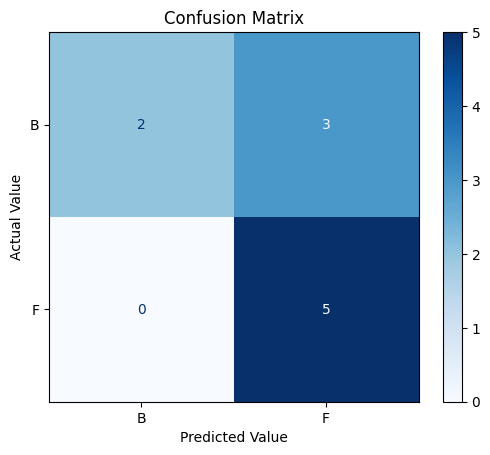

In [56]:
# Confusion matrix
cm = confusion_matrix(y_test_raw, y_pred, labels=range(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.show()
